In [ ]:
import math 
import cmath
import numpy as np
import pandas as pd
from scipy import fftpack
from scipy import interpolate

def extreme_index(data):
    max_index=[]
    min_index=[]
    dx=np.zeros(len(data))
    dx[:-1]=np.diff(data)
    dx[-1]=dx[-2]
    dx=np.sign(dx)
    d2x=np.zeros(len(data))
    d2x[1:]=np.diff(dx)
    d2x[0]=d2x[1]
    for i in np.arange(1,len(d2x)-1):
        if d2x[i]==-2:
            max_index.append(i)
        if d2x[i]==2:
            min_index.append(i)                 
    return max_index,min_index

def get_envelope(data,border_type='OMIT',interpolation='cubic'):
    imf={'x':data['Time (s)'],'y_pri':data['Acceleration x (m/s^2)'],'y_new':data['Acceleration x (m/s^2)']}
    if interpolation=='cubic':
        if border_type=='OMIT':
            max_index,min_index=extreme_index(data['y'])
            if len(max_index)>3 and len(min_index)>3:                                      #这样设置，包含了多种OMIT方法下的情形，如递减、极大值与极小值点均唯一等情况。这里数字需要自己设定（考虑到边界条件，此值应大于3）。
                cubic_max = interpolate.interp1d(np.array(data['x'])[max_index],np.array(data['y'])[max_index],kind='cubic') 
                cubic_min = interpolate.interp1d(np.array(data['x'])[min_index],np.array(data['y'])[min_index],kind='cubic')
                data_x_temp_start=data['x'][max_index[0]:] if max_index[0]>min_index[0] else data['x'][min_index[0]:]
                data_x_temp_end=data['x'][:max_index[-1]+1] if max_index[-1]<min_index[-1] else data['x'][:min_index[-1]+1]
                data_x_temp=list(set(data_x_temp_start).intersection(set(data_x_temp_end)))#取交集
                data_x_temp.sort()                                                         #排序，保证x序列递增
                envelope_max = cubic_max(data_x_temp)                                      #得到的数据类型为ndarray
                envelope_min = cubic_min(data_x_temp) 
                envelope_ave=0.5*(envelope_max+envelope_min)
                t=pd.DataFrame({'x':data['x'],'y':data['y']})                              #构造字典，根据得到的data_x_temp对data['y']进行更新
                temp=t[t['x']>=data_x_temp[0]]
                final=temp[temp['x']<=data_x_temp[len(data_x_temp)-1]]
                data_y_temp=final['y']  
                imf_temp=data_y_temp-envelope_ave
                imf['x']=np.array(data_x_temp)
                imf['y_pri']=data_y_temp
                imf['y_new']=imf_temp
                return imf
            else:
                return 1

def get_IMF(data,sift_mode='Cauthy',border_type='OMIT',interpolation='cubic',imf_num=2):
    data_temp={}
    data_new={}
    if sift_mode=='Cauthy':                          #类柯西准奏判定方法
        threshold=0.8                                #Huang参考值0.2-0.3，根据信号具体情况进行相应修改（很有必要！！）
        thre=2*threshold
        data_temp=data
        while thre>threshold:                        #获取第一个IMF分量，sift_mode进行控制.循环次数若过多，很容易导致极值点个数太少，无法求包络。需要修改相关函数
            imf=get_envelope(data_temp,border_type=border_type,interpolation=interpolation)
            if imf==1:                               #极点个数不满足要求的情形
                return data_temp,1                   #返回上一个筛选（sift_mode）过程的IMF与特征反馈信号
            else:
                top=sum((imf['y_pri']-imf['y_new'])**2)
                bottom=sum((imf['y_pri'])**2)
                data_temp={'x':imf['x'],'y':imf['y_new']}
                data_new={'x':imf['x'],'y':imf['y_pri']-imf['y_new']}
                thre=top/bottom
    if sift_mode=='Fixed':                           #以固定次数作为筛选终止条件，仍需添加IMF极值点数目限制
        data_temp=data
        while imf_num>0: 
            imf=get_envelope(data_temp,border_type=border_type,interpolation=interpolation)
            if imf==1:                               
                return data_temp,1                 
            else:               
                data_temp={'x':imf['x'],'y':imf['y_new']}
                data_new={'x':imf['x'],'y':imf['y_pri']-imf['y_new']}
                imf_num-=1
    return data_temp,data_new

def get_EMD(data,depose_mode='Monotonic',sift_mode='Cauthy',border_type='OMIT',interpolation='cubic',emd_num=5,imf_num=2):
    num=0
    imf_set={}
    if depose_mode=='Monotonic':                 #以IMF极值点数目作为分解终止条件（数学上具有一般性），包含了Huang的单调函数情形。
        mono=0
        data_temp=data
        while True:
            num+=1
            imf_temp,data_new=get_IMF(data_temp,sift_mode=sift_mode,border_type=border_type,interpolation=interpolation,imf_num=imf_num)
            imf_set[num]={'x'+str(num):imf_temp['x'],'y'+str(num):imf_temp['y']}
            if data_new==1:                      #达到EMD终止条件，退出循环
                break
            else:
                data_temp=data_new
    if depose_mode=='Fixed':                     #以固定次数作为分解终止条件，仍需添加IMF极值点数目限制
        data_temp=data                           
        if emd_num==1:
            imf_temp,data_new=get_IMF(data_temp,sift_mode=sift_mode,border_type=border_type,interpolation=interpolation,imf_num=imf_num)
            imf_set[1]={'x1':imf_temp['x'],'y1':imf_temp['y']}
        else:
            while emd_num>0:
                num+=1
                imf_temp,data_new=get_IMF(data_temp,sift_mode=sift_mode,border_type=border_type,interpolation=interpolation,imf_num=imf_num)
                if emd_num>1:#3.9 EMD分解次数固定时（emd_num初始值大于1），最后一个IMF由原数据减去前列IMF得到。如果不需要这样处理，注释掉这部分判断语句即可
                    imf_set[num]={'x'+str(num):imf_temp['x'],'y'+str(num):imf_temp['y']}
                else: 
                    imf_set[num]={'x'+str(num):data_temp['x'],'y'+str(num):data_temp['y']}
                if data_new==1:                      #达到EMD终止条件，退出循环
                    break
                else:
                    data_temp=data_new
                    emd_num-=1
    return num,imf_set 

def get_HT_FFT(imf_x,imf_y):
    amplitude=[]
    phase=[]
    ht_y=-fftpack.hilbert(imf_y)                       #此处Hilbert变换结果中，基于sin函数的移项角为-pi/2
    for num in range(len(imf_y)):
        com_y=complex(imf_y[num],ht_y[num])            
        amplitude.append(abs(com_y))                   #幅值
        phase.append(cmath.phase(com_y)+0.5*np.pi)     #相位。对Hilbert变换得到的角度进行修正，包括：初相角，角度范围变为[-pi/2,3pi/2]                                          
    dimf_y=np.zeros(len(imf_y))
    dimf_y[:-1]=np.diff(phase)
    if dimf_y[0]<0:                                    #注意到相位周期性变化的特征，考虑相位差分量突变的情形（正频率下突变量为负数），在突变处令差分量为前一时刻值（这种办法会造成一定误差，但不影响整体）。
        dimf_y[0]=dimf_y[1]                            #第一个点为负数的话，令其等于第二个值
    for check in range(1,len(dimf_y)-1):
        if dimf_y[check]<0:
            dimf_y[check]=dimf_y[check-1]        
    dimf_y[-1]=dimf_y[-2]
    dimf_x=np.zeros(len(imf_x))
    dimf_x[:-1]=np.diff(imf_x)
    dimf_x[-1]=dimf_x[-2]
    omega=dimf_y/dimf_x                                #频率（为简化程序，设末尾数据点频率与上一个点相同。潜在问题：相位边界点可能存在异常数据）
    return amplitude,phase,omega

def get_HT_FFT_set(imf_set):
    AF_set={}
    for i in range(len(imf_set)):                          #通过len(imf_set)获取imf数量，之前的函数给出了包含imf数量信息的返回值，是为了方便查看该信息，但这不是必须的
        imf_x=imf_set[i+1]['x'+str(i+1)]                   
        imf_y=np.array(list(imf_set[i+1]['y'+str(i+1)]))   #过程中转换为list以消除array原索引
        dimf_x=np.zeros(len(imf_x))
        dimf_x[:-1]=np.diff(imf_x)
        dimf_x[-1]=dimf_x[-2]
        amplitude,phase,omega=get_HT_FFT(imf_x,imf_y)
        real_omega=np.zeros(len(omega))
        real_omega[0]=omega[0]
        for j in range(1,len(real_omega)):
            real_omega[j]=(omega[j-1]-real_omega[j-1])*dimf_x[j]/imf_x[j-1]+real_omega[j-1]
        #根据情况选择omega或是real_omega
        AF_set[i+1]={'x'+str(i+1):imf_set[i+1]['x'+str(i+1)],'amplitude'+str(i+1):amplitude,'phase'+str(i+1):phase,'omega'+str(i+1):omega} 
    return AF_set

path1 = r"D:\HongliCup\题目B\高成本传感器数据\High quality sensor 08.csv"
data = pd.read_csv(path1)
#t = df['Time (s)']
#data = df['Acceleration x (m/s^2)']

print(get_EMD(data))



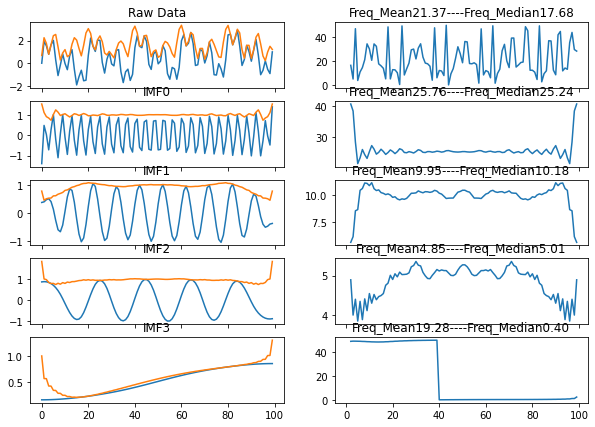

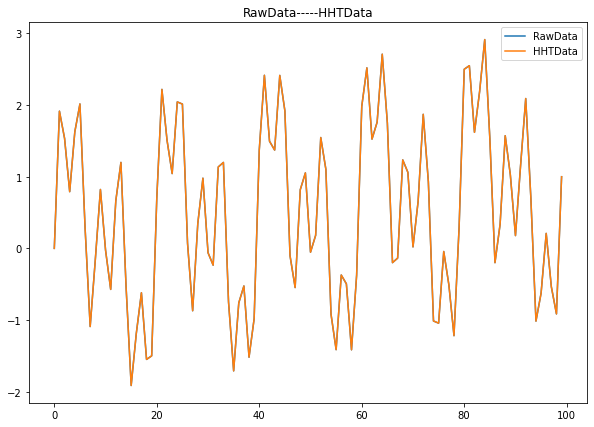

FileNotFoundError: File does not exist: F:\BaiduNetdiskDownload\BCICompetition\BCICIV_2a_gdf\Train\Fif\A02T_epo.fif

In [12]:
# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyhht import EMD
from scipy.signal import hilbert
import tftb.processing
import mne
 
 
# 定义HHT的计算分析函数
def HHTAnalysis(eegRaw, fs):
    # 进行EMD分解
    decomposer = EMD(eegRaw)
    # 获取EMD分解后的IMF成分
    imfs = decomposer.decompose()
    # 分解后的组分数
    n_components = imfs.shape[0]
    # 定义绘图，包括原始数据以及各组分数据
    fig, axes = plt.subplots(n_components + 1, 2, figsize=(10, 7), sharex=True, sharey=False)
    # 绘制原始数据
    axes[0][0].plot(eegRaw)
    # 原始数据的Hilbert变换
    eegRawHT = hilbert(eegRaw)
    # 绘制原始数据Hilbert变换的结果
    axes[0][0].plot(abs(eegRawHT))
    # 设置绘图标题
    axes[0][0].set_title('Raw Data')
    # 计算Hilbert变换后的瞬时频率
    instf, timestamps = tftb.processing.inst_freq(eegRawHT)
    # 绘制瞬时频率，这里乘以fs是正则化频率到真实频率的转换
    axes[0][1].plot(timestamps, instf * fs)
    # 计算瞬时频率的均值和中位数
    axes[0][1].set_title('Freq_Mean{:.2f}----Freq_Median{:.2f}'.format(np.mean(instf * fs), np.median(instf * fs)))
 
    # 计算并绘制各个组分
    for iter in range(n_components):
        # 绘制分解后的IMF组分
        axes[iter + 1][0].plot(imfs[iter])
        # 计算各组分的Hilbert变换
        imfsHT = hilbert(imfs[iter])
        # 绘制各组分的Hilber变换
        axes[iter + 1][0].plot(abs(imfsHT))
        # 设置图名
        axes[iter + 1][0].set_title('IMF{}'.format(iter))
        # 计算各组分Hilbert变换后的瞬时频率
        instf, timestamps = tftb.processing.inst_freq(imfsHT)
        # 绘制瞬时频率，这里乘以fs是正则化频率到真实频率的转换
        axes[iter + 1][1].plot(timestamps, instf * fs)
        # 计算瞬时频率的均值和中位数
        axes[iter + 1][1].set_title('Freq_Mean{:.2f}----Freq_Median{:.2f}'.format(np.mean(instf * fs), np.median(instf * fs)))
    plt.show()
 
 
# 定义HHT的滤波函数，提取部分EMD组分
def HHTFilter(eegRaw, componentsRetain):
    # 进行EMD分解
    decomposer = EMD(eegRaw)
    # 获取EMD分解后的IMF成分
    imfs = decomposer.decompose()
    # 选取需要保留的EMD组分，并且将其合成信号
    eegRetain = np.sum(imfs[componentsRetain], axis=0)
 
    # 绘图
    plt.figure(figsize=(10, 7))
    # 绘制原始数据
    plt.plot(eegRaw, label='RawData')
    # 绘制保留组分合成的数据
    plt.plot(eegRetain, label='HHTData')
    # 绘制标题
    plt.title('RawData-----HHTData')
    # 绘制图例
    plt.legend()
    plt.show()
    return eegRetain
 
if __name__ == '__main__':
####################示例数据分析##################################
    # 生成0-1时间序列，共100个点
    t = np.linspace(0, 1, 100)
    # 生成频率为5Hz、10Hz、25Hz的正弦信号累加
    modes = np.sin(2 * np.pi * 5 * t) + np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 25 * t)
    # 信号和时间累加，相当于添加噪声
    eegRaw = modes + t
    # fs为采样频率，用于正则化频率和真实频率的转换
    fs = 100
    # 进行HHT分析

    HHTAnalysis(eegRaw, fs)
    # 选取需要保留的信号进行合成，也就是相当于滤波
    eegRetain = HHTFilter(eegRaw, [0, 1, 2, 3])
######################真实数据分析#################################
    # 加载fif格式的数据
    epochs = mne.read_epochs(r'F:\BaiduNetdiskDownload\BCICompetition\BCICIV_2a_gdf\Train\Fif\A02T_epo.fif')
    # 获取采样频率
    sfreq = epochs.info['sfreq']
    # 想要分析的数据
    eegData = epochs.get_data()[0][0]
    HHTAnalysis(eegData, sfreq)
    HHTFilter(eegData, [0, 1, 2, 3, 4, 5, 6, 7, 8])

d:\Anaconda\lib\site-packages\emd\support.py:225: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  out_args[idx] = out_args[idx][:, np.newaxis]


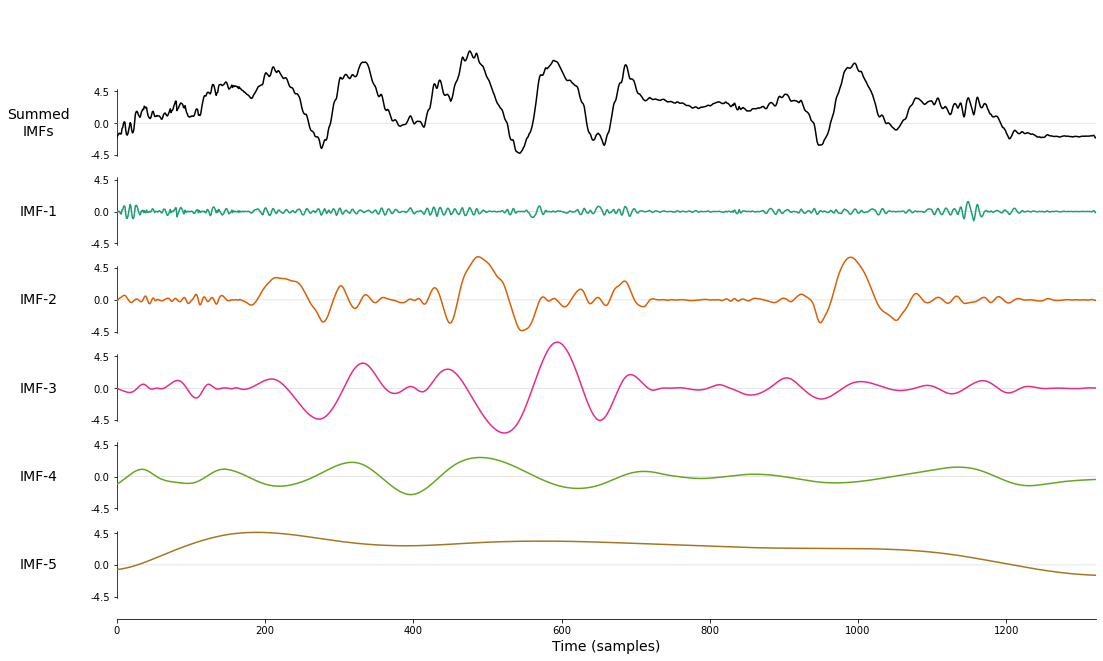

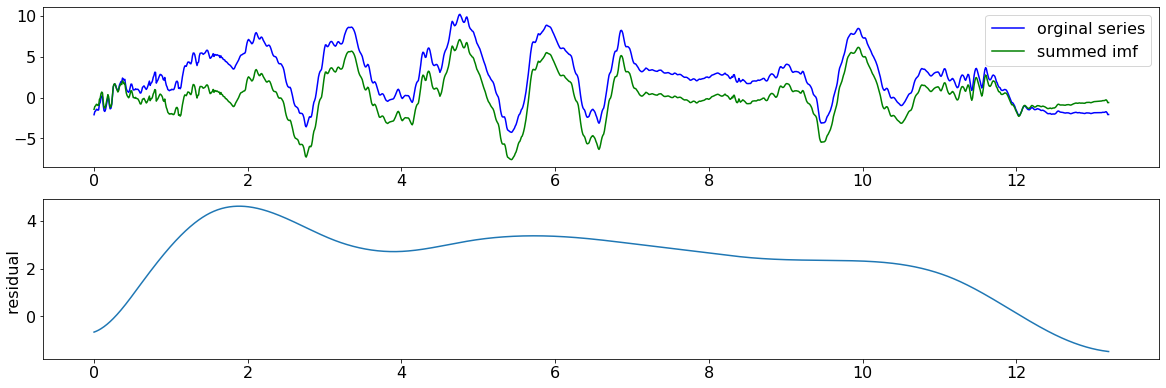

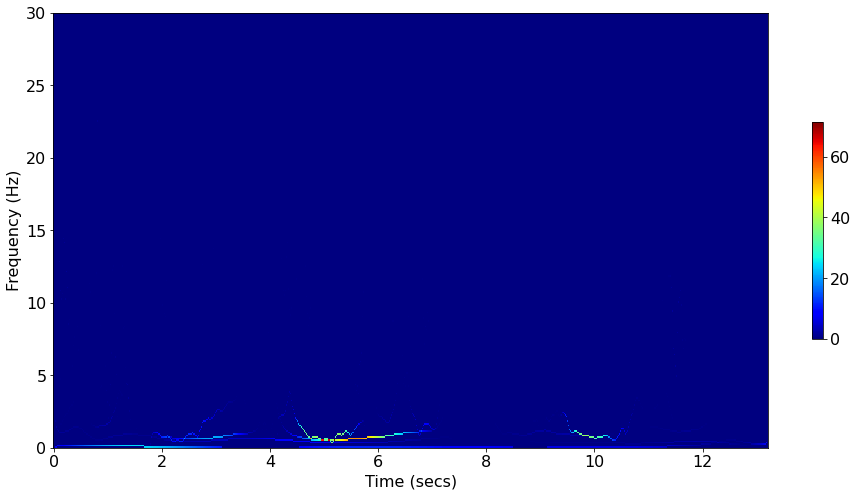

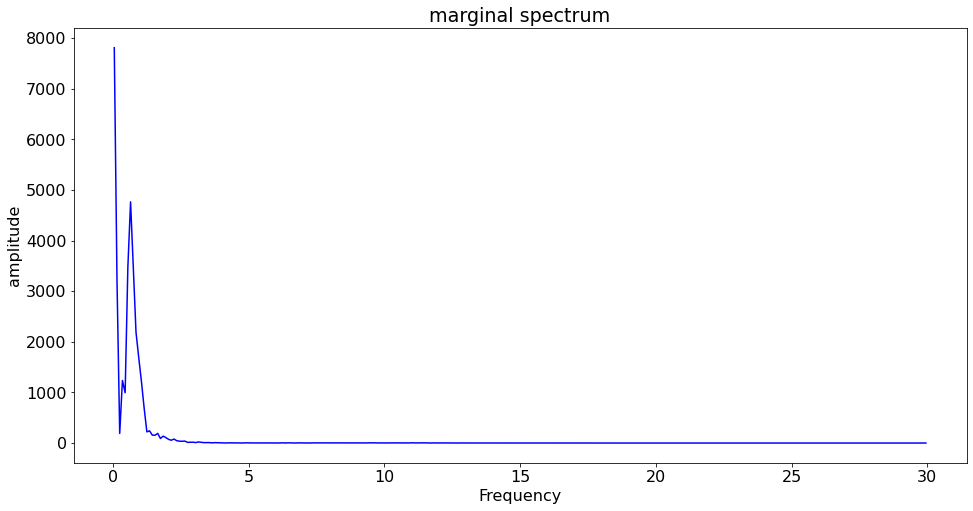

RMSE= 2.7717432573250957
snr= -0.25186800521398983


In [52]:
import emd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
path1 = r"D:\HongliCup\题目B\低成本传感器数据\low-cost sensor B 02.xls"
df = pd.read_excel(path1)
time_vect = df['Time (s)']
time_vect = np.array(time_vect)
x = df['Acceleration x (m/s^2)']
plt.rc('font',size = 16)
'''
sample_rate = 1/(time_vect[1]-time_vect[0])
seconds = time_vect.tail(1)
num_samples = sample_rate*seconds
'''

'''
time_vect = np.linspace(0, seconds, num_samples)
# 信号合成
x = 1.5*np.sin(2*np.pi*7*time_vect+3)
x += np.cos(2*np.pi*1*time_vect)
x += 0.8*np.cos(2*np.pi*3*time_vect)
'''

'''
time_vect = np.array(time_vect)
# emd分解

imf_opts = {'sd_thresh': 0.3}  # 设置sift算法停止的默认阈值
imf = emd.sift.sift(x, imf_opts=imf_opts)

# imf = emd.sift.sift(x)
# 瞬时相位/幅值/频率
IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
# HHT 谱
freq_range = (0, 30, 300)  # 0 to 10Hz in 100 steps
f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)

# 绘图
plt.figure(figsize=(16, 8))
#plt.subplot(211, frameon=False)
plt.plot(time_vect, x, 'k')
plt.plot(time_vect, imf[:, 0]-5, 'r')
plt.plot(time_vect, imf[:, 1]-8, 'g')
plt.plot(time_vect, imf[:, 2]-12, 'b')
plt.xlim(time_vect[0], time_vect[-1])
plt.grid(True)
plt.savefig('1.png',dpi=300)
#plt.subplot(212)
fig = plt.figure(figsize=(16,8))
#plt.pcolormesh(time_vect, f, hht, cmap='ocean_r')
a=plt.pcolormesh(time_vect, f, hht, cmap='jet')
fig.colorbar(a,shrink=0.5)
fig.colorbar
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (secs)')
#plt.grid(True)
plt.savefig('2.png',dpi=300)
plt.show()

# 边际谱
bjp = np.sum(hht,1)
fig = plt.figure(figsize=(16,8))
plt.plot(f, bjp, 'b')
plt.title('marginal spectrum');
plt.ylabel('amplitude')
plt.xlabel('Frequency')
plt.savefig('3.png',dpi=300)
plt.show()
'''


def emd_model(ts):
    """
    parameter free model
    :param ts: 1d array shape:[样本数,]
    :return: imf ndarray shape:[样本数，模态分量数目]
    """
    imf_opts = {'sd_thresh': 0.3}  # 设置sift算法停止的默认阈值
    imf = emd.sift.sift(ts, imf_opts=imf_opts)
    emd.plotting.plot_imfs(imf)
    return imf

imf_ = emd_model(x)

def emd_vis(imf,ts,time_vect):
    """
    see the residual , imf and orginal time series
    :param imf: 本征模态分量，[n_samples,n components]
    :return:
    """
    imfs,residual=imf[:,:-1],imf[:,-1]
    sum_imf=np.sum(imf[:,:-1],axis=1)
    plt.figure(figsize=(20, 10))
    plt.subplot(311)
    plt.plot(time_vect,ts, label='orginal series', color='blue')
    plt.plot(time_vect,sum_imf, label="summed imf", color='green')
    plt.legend(loc='best')
    # plt.ylabel("orginal series")

    plt.subplot(312)
    plt.plot(time_vect,residual)
    plt.ylabel("residual ")

    sample_rate = 1/(time_vect[1]-time_vect[0])
    seconds = time_vect[-1]
    num_samples = sample_rate*seconds
    IP, IF, IA = emd.spectra.frequency_transform(imf, sample_rate, 'hilbert')
    # HHT 谱
    freq_range = (0, 30, 300)  # 0 to 10Hz in 100 steps
    f, hht = emd.spectra.hilberthuang(IF, IA, freq_range, sum_time=False)
    fig = plt.figure(figsize=(16,8))
    # plt.pcolormesh(time_vect, f, hht, cmap='ocean_r')
    a=plt.pcolormesh(time_vect, f, hht, cmap='jet')
    fig.colorbar(a,shrink=0.5)
    fig.colorbar
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (secs)')
    #plt.grid(True)
    plt.savefig('2.png',dpi=300)
    plt.show()
    # 边际谱
    bjp = np.sum(hht,1)
    fig = plt.figure(figsize=(16,8))
    plt.plot(f, bjp, 'b')
    plt.title('marginal spectrum');
    plt.ylabel('amplitude')
    plt.xlabel('Frequency')
    plt.savefig('3.png',dpi=300)
    plt.show()

    return

emd_vis(imf_,x,time_vect)

sum_imf=np.sum(imf_[:,:-1],axis=1)
y = x
y_hat = sum_imf
num3 = len(y)
y_hat = y_hat[0:num3]
RMSE = np.linalg.norm(y-y_hat, ord=2)/len(y)**0.5
print('RMSE=',RMSE)

def SNR_singlech(S, SN):
    # S = S-np.mean(S)# 消除直流分量
    # S = S/np.max(np.abs(S))#幅值归一化
    # mean_S = (np.sum(S))/(len(S))#纯信号的平均值
    PS = np.sum(S*S)
    # PS = np.sum((S-mean_S)*(S-mean_S))
    PN = np.sum((S-SN)*(S-SN))
    snr=10*math.log((PS/PN), 10)
    return(snr)

num3 = len(y)
y_hat = y_hat[0:num3]
S = y_hat
SN = y
snr = SNR_singlech(S, SN)
# snr = np.round(snr)#四舍五入
print('snr=', snr)